# Открытые данные для NLP

В этом семинаре мы рассмотрим несколько источников данных, которые могут быть полезны при решении NLP задач. В следующих семинарах мы будем часто к ним обращаться. 

## Wikipedia

Начнем с википедии. Это полностью открытая, бесплатная, постоянно обновляемая, многоязычная энциклопедия. Все эти качества делают ее очень полезным ресурсом в NLP. 

В питоне есть несколько библиотек, упрощающих работу с API. Первая из них так и называется - wikipedia. Давайте посмотрим, что можно делать с ее попощью

In [12]:
# %pip install wikipedia

In [13]:
import wikipedia
import numpy as np
import os
import json
import requests

## Wiki data по разным языкам

Можно посмотреть какие языки есть в википедии и какие коды им соответствуют

In [69]:
code2lang = wikipedia.languages()

In [73]:
# больше 500 языков!
len(code2lang)

518

In [74]:
# ключ - код языка
# значение - его название
list(code2lang.items())[:10]

[('aa', 'Qafár af'),
 ('ab', 'аԥсшәа'),
 ('abs', 'bahasa ambon'),
 ('ace', 'Acèh'),
 ('acm', 'عراقي'),
 ('ady', 'адыгабзэ'),
 ('ady-cyrl', 'адыгабзэ'),
 ('aeb', 'تونسي / Tûnsî'),
 ('aeb-arab', 'تونسي'),
 ('aeb-latn', 'Tûnsî')]

In [76]:
code2lang['ru'], code2lang['en']

('русский', 'English')

Можно выбрать небольшой список языков

In [16]:
langs = ['be', 'bg', 'ky', 'lez' , 'mhr', 'mn', 'mk', 'mo', 'ru', 'sty', 'uk', 'en']

In [17]:
# расшифровка 
[(lang, code2lang[lang]) for lang  in langs]

[('be', 'беларуская'),
 ('bg', 'български'),
 ('ky', 'кыргызча'),
 ('lez', 'лезги'),
 ('mhr', 'олык марий'),
 ('mn', 'монгол'),
 ('mk', 'македонски'),
 ('mo', 'молдовеняскэ'),
 ('ru', 'русский'),
 ('sty', 'себертатар'),
 ('uk', 'українська'),
 ('en', 'English')]

А потом загрузить какие-то случайные статьи для этих языков с помощью функции `wikipedia.random(n)` (n - число статей)

In [85]:
wikipedia.random(1)

'Сьера-Невада'

Скачивание занимает некоторое время и может выдавать всякие непредсказуемые ошибки, поэтому не забывайте про добавлять обработчик исключения в аналогичные функции.

Например, может быть вот такая ошибка

In [86]:
wikipedia.page("Сьера-Невада")

DisambiguationError: "Сьера-Невада" may refer to: 
Сьера-Невада, Іспанія
Сьера-Невада, ЗША
Сьера-Невада-дэ-Санта-Марта

Она бывает, когда есть несколько статей с таким названием. Ее можно поправить вот так, выбрав случайный вариант из доступных:

In [88]:
try:
    p = wikipedia.page("Сьера-Невада")
except wikipedia.DisambiguationError as e:
    random_option = np.random.choice(e.options)
    p = wikipedia.page(random_option)

/Users/mnefedov/miniforge3/envs/tf2/lib/python3.9/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/mnefedov/miniforge3/envs/tf2/lib/python3.9/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [91]:
p

<WikipediaPage 'Сьера-Невада-дэ-Санта-Марта'>

In [93]:
def load_with_disambigution(page):
    try:
        p = wikipedia.page(page)
    except wikipedia.DisambiguationError as e:
        random_option = np.random.choice(e.options)
        p = wikipedia.page(random_option)
    return p

In [94]:
def get_texts_for_lang(lang, n=100): # функция для скачивания статей из википедии
    # вот так можно зафиксировать язык
    wikipedia.set_lang(lang)
    wiki_content = []
    
    # random достает только ссылки на статьи
    pages = wikipedia.random(n)
    
    for page_name in pages:
        try:
            # чтобы загрузить контент статьи можно вызвать функцию .page
            page = load_with_disambigution(page_name)
        
        except Exception as e:
            print('Skipping page {}'.format(page_name), e)
            continue

        wiki_content.append(f'{page.title}\n{page.content.replace("==", "")}')

    return wiki_content

Скачиваем по 20 случайных статей для каждого языка

In [95]:
%%time

wiki_texts = {}

for lang in langs:
    try:
        wiki_texts[lang] = get_texts_for_lang(lang, 20)
    except Exception as e:
        print('ERROR ON - ', lang, e)
        continue
    
    print(lang, len(wiki_texts[lang]))

be 20
bg 20
ky 20
lez 20
Skipping page Майский "Майский" may refer to: 
Майский
Майский
Майский
Майский
Skipping page Куэрсола "Куэрсола" may refer to: 
Куэрсола
Куэрсола
mhr 18
mn 20
mk 20
ERROR ON -  mo Expecting value: line 1 column 1 (char 0)
ru 20
ERROR ON -  sty HTTPConnectionPool(host='sty.wikipedia.org', port=80): Max retries exceeded with url: /w/api.php?list=random&rnnamespace=0&rnlimit=20&format=json&action=query (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x2a2d508b0>: Failed to resolve 'sty.wikipedia.org' ([Errno 8] nodename nor servname provided, or not known)"))
Skipping page Ліннамяе "Ліннамяе" may refer to: 
Ліннамяе
Ліннамяе
uk 19
en 20
CPU times: user 36.8 s, sys: 3.82 s, total: 40.6 s
Wall time: 4min 47s


Что можешь сделать с такими данными? Например, можно обучить модель для классификации языка

### Классификация языка

Можно попробовать классифицировать язык аналогично тому, как вы дизабигуировали значение слов. 

Создадим множества символов, представляющих язык, по скачанным текстам. И сделаем функцию, которая предсказывает язык на основе пересечения множеств символов. При этом нас не итересуют числа и знаки пунктуации

In [96]:
from collections import defaultdict
from string import digits
import re

digits = set(digits)

In [105]:
# создаем словарь уникальных символов для каждого языка
lang2chars = defaultdict(set)


for lang in wiki_texts:
    for text in wiki_texts[lang]:
        char_set = set(re.findall("\w", text.lower())) - digits
        lang2chars[lang].update(char_set)

In [108]:
lang2chars.keys()

dict_keys(['be', 'bg', 'ky', 'lez', 'mhr', 'mn', 'mk', 'ru', 'en', 'uk'])

In [109]:
# посмотрим на какой-нибудь язык
len(lang2chars['ru'])

67

In [113]:
# символы для этого языка
list(lang2chars['ru'])[:5]

['п', 'г', 'я', 'i', 'y']

In [111]:
def predict_language(text, lang2char):
    text_chars = set(re.findall('\w', text.lower())) - digits
    lang2sim = {}
    
    for lang in lang2char:
        intersect = len(text_chars & lang2char[lang])
        lang2sim[lang] = intersect
    
    return max(lang2sim.items(), key=lambda x: x[1])[0]

Попробуем предсказать

In [114]:
predict_language('какой это язык', lang2chars)

'be'

Неправильно, но по одному тексту судить о качестве трудно. Отклассифицурем все тексты, которые у нас есть.

Для метрик удобно использовать функцию classification_report и confusion_matrix

In [115]:
from sklearn.metrics import classification_report, confusion_matrix

In [116]:
true_labels = []
predicted_labels = []

for lang in wiki_texts:
    for text in wiki_texts[lang]:
        true_labels.append(lang)
        predicted_labels.append(predict_language(text, lang2chars))

In [118]:
true_labels[0], predicted_labels[0]

('be', 'be')

classification_report считает сразу все основные классификационные метрики (точность, полноту, f1 меру) для каждого уникального класса, а также усредненные метрики

In [45]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

          be       0.48      1.00      0.65        10
          bg       0.77      1.00      0.87        10
          en       1.00      0.11      0.20         9
          ky       0.77      1.00      0.87        10
         lez       1.00      1.00      1.00        10
         mhr       1.00      0.90      0.95        10
          mk       1.00      1.00      1.00        10
          mn       0.78      0.70      0.74        10
          ru       1.00      0.30      0.46        10

    accuracy                           0.79        89
   macro avg       0.87      0.78      0.75        89
weighted avg       0.86      0.79      0.75        89



confusion_matrix помогает посмотреть на ошибки. Она возвращает квадратную матрицу, где каждая ячейка это количество объектов, для которых был предсказан класс, который находится в этой колонке, но который на самом деле является классом, который стоит в строке. 

Идеальная матрица ошибок - диагональная, то есть все было предсказано так, как оно есть на самом деле

In [120]:
labels = list(set(true_labels))
print(confusion_matrix(true_labels, predicted_labels, labels = labels))

[[18  0  0  2  0  0  0  0  0  0]
 [ 0 16  0  2  0  0  0  0  0  0]
 [ 0  0 19  0  0  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0  0  0]
 [13  0  0  0  7  0  0  0  0  0]
 [ 0  0  0 12  0  8  0  0  0  0]
 [ 0  0  0  1  0  0 19  0  0  0]
 [ 0  0  0  0  0  0  0 20  0  0]
 [ 1  0  0 14  0  0  0  0  5  0]
 [ 0  0  0  9  0  3  0  0  2  6]]


Такую матрицу удобно визуализировать через heatmap

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

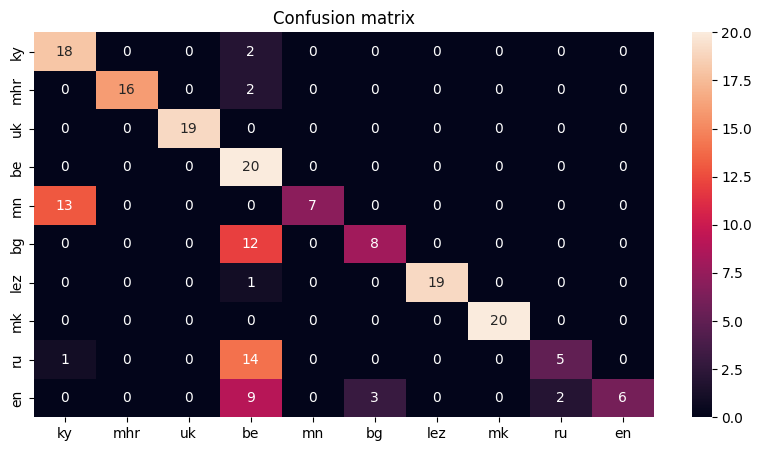

In [123]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data=confusion_matrix(true_labels, predicted_labels, labels = labels), 
            annot=True, 
            fmt="d", xticklabels=labels, yticklabels=labels, ax=ax)
plt.title("Confusion matrix")
plt.show()

Если посмотреть на ненулевые значение не на диагонали, то можно понять какие классы путаются между собой. Самая частая ошибка - be и ru

### Wiki data по категориям

Есть еще одна библиотека для работы с вики - `wikipediaapi`  
Её можно использовать, чтобы скачать категории и статьи по категориям

In [64]:
# %pip install wikipedia_api

In [22]:
import wikipediaapi
import wikipedia
from time import sleep
import numpy as np
from string import punctuation
import re

# в этой библиотеки нужно указывать название своего агента
# в нем желательно указать имейл 
# честно говоря не знаю зачем это нужно
# но наверное с пустыми агентами можно получить бан
email = "manefedov26@gmail.com"
wiki_client = wikipediaapi.Wikipedia(f"HSENLPCOURSE/0.0 (; {email})",
                                   language='ru')
wikipedia.set_lang('ru')

Вот так можно выгрузить все статьи для конкретной категории. 

In [6]:
wiki_client.categorymembers(wiki_client.page("Категория:Лингвистика"))

{'Лингвистика': Лингвистика (id: ??, ns: 0),
 'Лингвоним': Лингвоним (id: ??, ns: 0),
 'Общая лингвистика': Общая лингвистика (id: ??, ns: 0),
 'Портал:Лингвистика': Портал:Лингвистика (id: ??, ns: 100),
 'Адлог': Адлог (id: ??, ns: 0),
 'Анадиплосис': Анадиплосис (id: ??, ns: 0),
 'Анафора (лингвистика)': Анафора (лингвистика) (id: ??, ns: 0),
 'Безопасный (статус языка)': Безопасный (статус языка) (id: ??, ns: 0),
 'Билингва (палеография)': Билингва (палеография) (id: ??, ns: 0),
 'Вариантность (лингвистика)': Вариантность (лингвистика) (id: ??, ns: 0),
 'Вербализация (лингвистика)': Вербализация (лингвистика) (id: ??, ns: 0),
 'Геолингвистика': Геолингвистика (id: ??, ns: 0),
 'Гибридное слово': Гибридное слово (id: ??, ns: 0),
 'Глоссирование': Глоссирование (id: ??, ns: 0),
 'Диахрония и синхрония': Диахрония и синхрония (id: ??, ns: 0),
 'Дифференциальный признак': Дифференциальный признак (id: ??, ns: 0),
 'Есть угроза исчезновения': Есть угроза исчезновения (id: ??, ns: 0),
 'Ж

Для русского категории можно посмотреть вот тут - https://ru.wikipedia.org/wiki/%D0%A1%D0%BB%D1%83%D0%B6%D0%B5%D0%B1%D0%BD%D0%B0%D1%8F:%D0%9A%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B8
Наверное есть способ вытащить этот список автоматически, но я не нашел

В результате выше есть подкатегории и для них хотелось бы спуститься ниже и достать сами статьи. Для этого я написал рекурсивную функцию, которая проверяет название статьи и если это обычная статья, то возвращает ее, а если это категория, то вызывает функцию на этой категории (так рекурсивно будут проверться подстатьи пока не дойдется до всех статей).

Такой обход категории работает не быстро поэтому я написал ее через генератор - статьи возвращаются по одной, чтобы можно было отсчитать нужное количество или остановится когда надоест

In [17]:
def get_articles_in_whole_category(cat):
    # вытаскиваем список статей по категории
    try:
        articles = wiki_client.categorymembers(wiki_client.page(cat))
    except KeyError:
        return None

    for article in articles:

        if article.startswith('Шаблон'): # шаблоны пропускаем
            continue

        elif article.startswith('Категори'): # рекурсивно вызываем для подкатегорий
            for sub_article in get_articles_in_whole_category(article):
                if sub_article is not None:
                    yield sub_article

        else: # если просто статья до добавляем
            yield article

In [18]:
def get_content(name):
    try:
        text = wikipedia.page(name).content
    except Exception as e:
        print(e)
        text = ""
    
    return text


Скачаем 100 статей для категории лингвистика

In [33]:
%%time

article_names = []
article_contents = []
for i, article in enumerate(get_articles_in_whole_category("Категория:Лингвистика")):
    if i > 100:
        break
    
    article_names.append(article)
    article_contents.append(get_content(article))

CPU times: user 11.8 s, sys: 1.19 s, total: 13 s
Wall time: 1min 42s


In [34]:
article_contents[0]

'Лингви́стика (от лат. lingua «язык»), языкозна́ние, языкове́дение — наука, изучающая язык.\nЭто наука о естественном человеческом языке вообще и обо всех языках мира как его индивидуализированных представителях.\nВ широком смысле слова лингвистика подразделяется на научную и практическую. Чаще всего под лингвистикой подразумевается именно научная лингвистика. Лингвистика связана с семиотикой как наукой о знаковых системах.\nЛингвистикой профессионально занимаются учёные-лингвисты.\n\n\n== Предмет лингвистики ==\nЛингвистика изучает не только существующие (существовавшие или возможные в будущем) языки, но и человеческий язык вообще. Язык не дан лингвисту в прямом наблюдении; непосредственно наблюдаемы лишь факты речи, или языковые явления, то есть речевые акты носителей живого языка вместе с их результатами (текстами) или языковой материал (ограниченное число письменных текстов на мёртвом языке, которым уже никто не пользуется в качестве основного средства общения).\n\n\n=== Лингвистик

## Dump wiki

Собрания всех текущих статей регулярно выгладываются одним файлом - дампом. Вот тут можно посмотреть актуальные дампы по языкам - https://dumps.wikimedia.org/backup-index-bydb.html

Я перешел в ruwiki и скопировал ссылку на дамп - ruwiki-20231001-pages-articles-multistream.xml.bz2

In [ ]:
!wget https://dumps.wikimedia.org/ruwiki/20230920/ruwiki-20230920-pages-articles-multistream.xml.bz2

Для обработки дампа есть отдельная небольшая библиотека wikiextractor

In [ ]:
!git clone https://github.com/attardi/wikiextractor.git

In [39]:
cd wikiextractor

/Users/mnefedov/Desktop/course/compling_nlp_hse_course/notebooks/first_module_intro/wikiextractor/wikiextractor


Когда сам дамп скачался можно запустить скрипт и он преобразует его в более понятный формат

In [51]:
!python -m wikiextractor.WikiExtractor -o ./data/wiki/ --no-templates --processes 8 ../ruwiki-20230920-pages-articles-multistream.xml.bz2

INFO: Starting page extraction from ../ruwiki-20230920-pages-articles-multistream.xml.bz2.
INFO: Using 8 extract processes.
^C
Traceback (most recent call last):
  File "/Users/mnefedov/miniforge3/envs/tf2/lib/python3.9/runpy.py", line 197, in _run_module_as_main
Process ForkProcess-1:
    return _run_code(code, main_globals, None,
  File "/Users/mnefedov/miniforge3/envs/tf2/lib/python3.9/runpy.py", line 87, in _run_code
Process ForkProcess-2:
    exec(code, run_globals)
  File "/Users/mnefedov/Desktop/course/compling_nlp_hse_course/notebooks/first_module_intro/wikiextractor/wikiextractor/WikiExtractor.py", line 643, in <module>
    main()
  File "/Users/mnefedov/Desktop/course/compling_nlp_hse_course/notebooks/first_module_intro/wikiextractor/wikiextractor/WikiExtractor.py", line 639, in main
    process_dump(input_file, args.templates, output_path, file_size,
  File "/Users/mnefedov/Desktop/course/compling_nlp_hse_course/notebooks/first_module_intro/wikiextractor/wikiextractor/WikiEx

In [53]:
# данные будут разбиты на кусочки и сохранены в множестве файлов в подпапка data/wiki
# файл выглядит как-то так
# далее останется предобработь тексты и собрать их в один файл
open('data/wiki/AA/wiki_00').read()

'<doc id="4" url="https://ru.wikipedia.org/wiki?curid=4" title="Базовая статья">\nБазовая статья\n\n\n\n</doc>\n<doc id="7" url="https://ru.wikipedia.org/wiki?curid=7" title="Литва">\nЛитва\n\nЛитва́ ( ), официальное название\xa0— Лито́вская Респу́блика ()\xa0— государство, расположенное в Северной Европе. Площадь\xa0— км². Протяжённость с севера на юг\xa0— 280\xa0км, а с запада на восток\xa0— 370 км. Население составляет человек (август, 2023). Занимает 137-е место в мире по численности населения и 121-е по территории. Имеет выход к Балтийскому морю, расположена на его восточном побережье. Береговая линия составляет всего 99 км (наименьший показатель среди государств Балтии). На севере граничит с Латвией, на юго-востоке\xa0— с Белоруссией, на юго-западе\xa0— с Польшей и Калининградской областью России. По площади и населению является самым крупным государством из стран Балтии.\nСтолица\xa0— Вильнюс. Официальный язык\xa0— литовский. Денежная единица\xa0— евро.\nВосстановление независим

Потом еще можно взять вот такой скрипт - https://gist.github.com/snakers4/e0b0e68904db65671ca979639b337f7b

И вызвать его в той же директории, чтобы получился один csv файл - `python process_wikipedia.py`

# OpenCorpora

Википедию хорошо использовать, когда нужны просто тексты. Но иногда нужен настоящий корпус (с разметками и всем таким), например для решения задачи разрешения морфологической омонимии. Тогда можно воспользоваться НКРЯ и OpenCorpora. 

НКРЯ лучше и больше, но там нужно запрашивать и подписывать какое-то соглашение. Поэтому мы возьмем OpenCorpora, который можно скачать без этих сложностей вот тут - http://opencorpora.org/?page=downloads (нужен снятнятой омонимией без UNK).

In [55]:
!wget https://opencorpora.org/files/export/annot/annot.opcorpora.no_ambig_strict.xml.bz2

--2023-10-09 19:26:00--  https://opencorpora.org/files/export/annot/annot.opcorpora.no_ambig_strict.xml.bz2
Resolving opencorpora.org (opencorpora.org)... 104.21.15.199, 172.67.163.210, 2606:4700:3031::ac43:a3d2, ...
Connecting to opencorpora.org (opencorpora.org)|104.21.15.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1435269 (1,4M) [application/x-bzip2]
Saving to: ‘annot.opcorpora.no_ambig_strict.xml.bz2’

annot.opcorpora.no_ 100%[===================>]   1,37M  --.-KB/s    in 0,08s   

2023-10-09 19:26:10 (16,7 MB/s) - ‘annot.opcorpora.no_ambig_strict.xml.bz2’ saved [1435269/1435269]



In [58]:
import bz2

with bz2.open('annot.opcorpora.no_ambig_strict.xml.bz2', 'rb') as f_in, open('annot.opcorpora.no_ambig_strict.xml', 'wb') as f_out:
    f_out.write(f_in.read())

In [59]:
from lxml import etree
from pymorphy2 import MorphAnalyzer
from sklearn.metrics import classification_report
import numpy as np
from collections import Counter

Сам корпус в xml. Для того, чтобы достать все в питоновские структуры данных, удобно использовать lxml и xpath. Xml очень похож на html, а xpath это просто путь до нужного объекта. 

In [60]:
open_corpora = etree.fromstring(open('annot.opcorpora.no_ambig_strict.xml', 'rb').read())

Так достанутся все предложения.

In [79]:
## чтобы не прописывать весь путь до tokens можно поставить // - он проверит все возможные варианты пока не дойдет до tokens
sentences = open_corpora.xpath('//tokens')

А так в отдельном предложении достанутся все слова.

In [84]:
# тут просто обращение по тэгу
tokens = sentences[0].xpath('token')

Для токена форма слова достается вот так:

In [87]:
# text хранится в атрибуте, к нему можно обратится через @
[token.xpath('@text')[0] for token in tokens]

['«', 'Школа', 'злословия', '»', 'учит', 'прикусить', 'язык']

А грамматическая информация вот так:

In [89]:
# грамматическая иформация чуть более вложена
[token.xpath('tfr/v/l/g/@v')[0] for token in tokens]

['PNCT', 'NOUN', 'NOUN', 'PNCT', 'VERB', 'INFN', 'NOUN']

Теперь можно пройтись по корпусу и перевести его в более удобный формат

In [104]:
corpus = []


for sentence in open_corpora.xpath('//tokens'):
    sent_tagged = []
    for token in sentence.xpath('token'):
        word = token.xpath('@text')
        gram_info = token.xpath('tfr/v/l/g/@v')
        sent_tagged.append([word[0]] + gram_info)
    
    corpus.append(sent_tagged)
        

In [105]:
# пример предложения с разметкой
corpus[0]

[['«', 'PNCT'],
 ['Школа', 'NOUN', 'inan', 'femn', 'sing', 'nomn'],
 ['злословия', 'NOUN', 'inan', 'neut', 'sing', 'gent'],
 ['»', 'PNCT'],
 ['учит', 'VERB', 'impf', 'tran', 'sing', '3per', 'pres', 'indc'],
 ['прикусить', 'INFN', 'perf', 'tran'],
 ['язык', 'NOUN', 'inan', 'masc', 'sing', 'accs']]

In [107]:
# пример предложения с разметкой
corpus[1]

[['Сохранится', 'VERB', 'perf', 'intr', 'sing', '3per', 'futr', 'indc'],
 ['ли', 'PRCL'],
 ['градус', 'NOUN', 'inan', 'masc', 'sing', 'nomn'],
 ['дискуссии', 'NOUN', 'inan', 'femn', 'sing', 'gent'],
 ['в', 'PREP'],
 ['новом', 'ADJF', 'Qual', 'masc', 'sing', 'loct'],
 ['сезоне', 'NOUN', 'inan', 'masc', 'sing', 'loct'],
 ['?', 'PNCT']]

## Зависимостный парсинг (Dependency parsing)
Еще один формат корпусов, про который стоит рассказать - это корпуса, размеченные деревьями зависимостей.

Зависимостный парсинг - одна из немногих задач, где лингвистика и компьютерные науки продуктивно взаимодействуют. Основную теорию тут разрабатывают лингвисты, они же размечают корпусы, а модели построены на самых последних разработках в области машинного обучения.

Лингвистическая часть это прежде всего Universal Dependcies - стандарт разметки отношений, объединяющий большое количество языков. 
    
На сайте Universal dependencies есть полное описание всех типов зависимостей, а также ссылки на доступные корпуса (там уже много языков):
http://universaldependencies.org/

Для русского стандартный корпус - Syntagrus:
https://github.com/UniversalDependencies/UD_Russian-SynTagRus

Еще есть корпус Taiga:
https://tatianashavrina.github.io/taiga_site/



Есть несколько хороших моделей, обученных на этих корпусах. **UDPipe** (от Карлова Университета в Чехии), **SyntaxNet** (Google), **MaltParser**, **TurkuNLP**, **Stanford NLP**. 

Лучшим выбором на данный момент является UDPipe - его просто установить и использовать, да и работает он неплохо. Подробнее про качество работы парсеров для русского языка вы можете узнать в этой статье - https://habr.com/ru/company/sberbank/blog/418701/ 

Попробуем UDPipe. Нужно установить пакет ufal.udpipe

In [108]:
!pip install ufal.udpipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.8/835.8 kB 6.2 MB/s eta 0:00:0000:0100:01


А чтобы было удобнее, установим ещё spacy_udpipe. Это spacy-подобный интерфейс к udpipe.

In [109]:
!pip install spacy-udpipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 19.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 791.5/791.5 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.4 MB/s eta 0:00:00
  Using cached langcodes-3.3.0-py3-none-any.whl (181 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 5.3 MB/s eta 0:00:00


In [110]:
import spacy_udpipe

In [2]:
# можно воспольоваться такой командой если вылезает PersmissionError
# !sudo chmod 777 /usr/local/lib/python3.x/site-packages/spacy_udpipe/models

Скачиваем модель для русского.

In [111]:
spacy_udpipe.download("ru")

Downloaded pre-trained UDPipe model for 'ru' language


Загружаем.

In [112]:
nlp = spacy_udpipe.load("ru")

Попробуем разобрать какой-нибудь текст.

In [113]:
text = ("Более 150 лет назад Майкл Фарадей предположил, "
        "что скользкость льда связана с возникновением тонкого " 
        "слоя жидкой воды на его поверхности.")

# text = 'Я написал любое другое предложение.'
doc = nlp(text)
for token in doc:
    print(token.i+1, token.text, token.lemma_, 
          token.pos_, '_', token.tag_, token.head.i+1, token.dep_, '_', '_')

1 Более более ADV _  3 nummod:gov _ _
2 150 150 NUM _  3 nummod _ _
3 лет год NOUN _  7 obl _ _
4 назад назад ADV _  3 advmod _ _
5 Майкл Майкл PROPN _  7 nsubj _ _
6 Фарадей Фарадей PROPN _  5 flat:name _ _
7 предположил предположить VERB _  7 ROOT _ _
8 , , PUNCT _  12 punct _ _
9 что что SCONJ _  12 mark _ _
10 скользкость скользкость NOUN _  12 nsubj:pass _ _
11 льда лед NOUN _  10 nmod _ _
12 связана связать VERB _  7 ccomp _ _
13 с с ADP _  14 case _ _
14 возникновением возникновение NOUN _  12 obl _ _
15 тонкого тонкий ADJ _  16 amod _ _
16 слоя слой NOUN _  14 nmod _ _
17 жидкой жидкий ADJ _  18 amod _ _
18 воды вода NOUN _  16 nmod _ _
19 на на ADP _  21 case _ _
20 его его DET _  21 det _ _
21 поверхности поверхность NOUN _  14 nmod _ _
22 . . PUNCT _  7 punct _ _


Формат, в которым мы напечатали текст, называется Conll (по названию конференции Conference on Computational Natural Language Learning, в рамках который проводились и проводятся соревнования по парсингу). 

In [147]:
tree = []

for token in doc:
    if token.dep_ == 'ROOT':
        tree.append('\t'.join([str(token.i+1), token.text, token.lemma_, 
          token.pos_, '_', token.tag_ or '_', str(0), token.dep_, '_', '_',]))
    else:
        tree.append('\t'.join([str(token.i+1), token.text, token.lemma_, 
          token.pos_, '_', token.tag_ or '_', str(token.head.i+1), token.dep_, '_', '_']))

Для работы с таким форматов в nltk есть специальный класс - DependencyGraph. Давайте посмотрим, как он работает.

In [149]:
from nltk.grammar import DependencyGrammar
from nltk.parse import DependencyGraph
from collections import Counter
import numpy as np
import re
import warnings
import os
warnings.filterwarnings('ignore')

Обрабатываем наше предложение через него.

In [150]:
d = DependencyGraph('\n'.join(tree))

Теперь элементы хранятся в словаре (ключи - индексы слов)

In [151]:
d.nodes

defaultdict(<function nltk.parse.dependencygraph.DependencyGraph.__init__.<locals>.<lambda>()>,
            {0: {'address': 0,
              'word': None,
              'lemma': None,
              'ctag': 'TOP',
              'tag': 'TOP',
              'feats': None,
              'head': None,
              'deps': defaultdict(list, {'ROOT': [7]}),
              'rel': None},
             1: {'address': 1,
              'word': 'Более',
              'lemma': 'более',
              'ctag': 'ADV',
              'tag': '_',
              'feats': '_',
              'head': 3,
              'deps': defaultdict(list, {}),
              'rel': 'nummod:gov'},
             3: {'address': 3,
              'word': 'лет',
              'lemma': 'год',
              'ctag': 'NOUN',
              'tag': '_',
              'feats': '_',
              'head': 7,
              'deps': defaultdict(list,
                          {'nummod:gov': [1], 'nummod': [2], 'advmod': [4]}),
              'rel

Есть ещё удобный метод .triples() который возращается все тройки СЛОВО_1 - зависимость - СЛОВО_2

In [152]:
d.root = d.nodes[0] # чтобы метод сработал нужно установить корневой элемент
list(d.triples())

[((None, 'TOP'), 'ROOT', ('предположил', 'VERB')),
 (('предположил', 'VERB'), 'obl', ('лет', 'NOUN')),
 (('лет', 'NOUN'), 'nummod:gov', ('Более', 'ADV')),
 (('лет', 'NOUN'), 'nummod', ('150', 'NUM')),
 (('лет', 'NOUN'), 'advmod', ('назад', 'ADV')),
 (('предположил', 'VERB'), 'nsubj', ('Майкл', 'PROPN')),
 (('Майкл', 'PROPN'), 'flat:name', ('Фарадей', 'PROPN')),
 (('предположил', 'VERB'), 'ccomp', ('связана', 'VERB')),
 (('связана', 'VERB'), 'punct', (',', 'PUNCT')),
 (('связана', 'VERB'), 'mark', ('что', 'SCONJ')),
 (('связана', 'VERB'), 'nsubj:pass', ('скользкость', 'NOUN')),
 (('скользкость', 'NOUN'), 'nmod', ('льда', 'NOUN')),
 (('связана', 'VERB'), 'obl', ('возникновением', 'NOUN')),
 (('возникновением', 'NOUN'), 'case', ('с', 'ADP')),
 (('возникновением', 'NOUN'), 'nmod', ('слоя', 'NOUN')),
 (('слоя', 'NOUN'), 'amod', ('тонкого', 'ADJ')),
 (('слоя', 'NOUN'), 'nmod', ('воды', 'NOUN')),
 (('воды', 'NOUN'), 'amod', ('жидкой', 'ADJ')),
 (('возникновением', 'NOUN'), 'nmod', ('поверхнос

## Для чего можно использовать зависимости?

Попробуем проанализировать тексты с помощью зависимостей. Сами парсить не будет, а возьмем уже готовые разборы из Тайги.

Я взял маленький кусочек (Arzamas) - скачать его можно тут - https://linghub.ru/static/Taiga/Arzamas.zip

In [154]:
!wget https://linghub.ru/static/Taiga/Arzamas.zip

--2023-10-09 19:52:49--  https://linghub.ru/static/Taiga/Arzamas.zip
Resolving linghub.ru (linghub.ru)... 89.175.46.138
Connecting to linghub.ru (linghub.ru)|89.175.46.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8110992 (7,7M) [application/zip]
Saving to: ‘Arzamas.zip’

Arzamas.zip         100%[===================>]   7,73M  2,19MB/s    in 4,8s    

2023-10-09 19:52:54 (1,62 MB/s) - ‘Arzamas.zip’ saved [8110992/8110992]



In [156]:
# !unzip Arzamas.zip

В нем есть папка с обработанными текстами. Соберем их в один список.

In [157]:
path = 'Arzamas/texts_tagged/'
files = [path+file for file in os.listdir(path)]

Посмотрим, что лежит в этих файлах.

In [165]:
file = open(files[1]).read()

Разобранные предложения в том же формате CONLL

In [166]:
tree = [x for x in file.split('\n\n')[0].split('\n')]

Перед разбором ещё может быть указана метаинформация (начало дока, параграфа, номер предложения, само предложения в изначальном виде).

In [167]:
tree

['# text = # newpar',
 '# sent_id = 10573',
 '# text = Великая французская революция началась с взятия Бастилии 14 июля 1789 года, но еще три года после этого в стране существовала монархия.',
 '1\tВеликая\tвеликий\tADJ\t_\tCase=Nom|Degree=Pos|Gender=Fem|Number=Sing\t3\tamod\t_\t_',
 '2\tфранцузская\tфранцузский\tADJ\t_\tCase=Nom|Degree=Pos|Gender=Fem|Number=Sing\t3\tamod\t_\t_',
 '3\tреволюция\tреволюция\tNOUN\t_\tAnimacy=Inan|Case=Nom|Gender=Fem|Number=Sing\t4\tnsubj\t_\t_',
 '4\tначалась\tначинаться\tVERB\t_\tAspect=Perf|Gender=Fem|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin|Voice=Mid\t0\troot\t_\t_',
 '5\tс\tс\tADP\t_\t_\t6\tcase\t_\t_',
 '6\tвзятия\tвзятие\tNOUN\t_\tAnimacy=Inan|Case=Gen|Gender=Neut|Number=Sing\t4\tobl\t_\t_',
 '7\tБастилии\tБастилия\tPROPN\t_\tAnimacy=Inan|Case=Gen|Gender=Fem|Number=Sing\t6\tnmod\t_\t_',
 '8\t14\t14\tNUM\t_\t_\t7\tnummod\t_\t_',
 '9\tиюля\tиюль\tNOUN\t_\tAnimacy=Inan|Case=Gen|Gender=Masc|Number=Sing\t8\tnmod\t_\t_',
 '10\t1789\t1789\tNUM\t_\t_\t

Но нам она не нужна. Соберем в один список все деревья.

In [168]:
trees = []

for file in files:
    parsed_sents = open(file).read().split('\n\n')
    
    for sent in parsed_sents:
        tree = [line for line in sent.split('\n') if line[0] != '#']
        trees.append('\n'.join(tree))
        

In [170]:
trees[1]

'1\tВеликая\tвеликий\tADJ\t_\tCase=Nom|Degree=Pos|Gender=Fem|Number=Sing\t3\tamod\t_\t_\n2\tфранцузская\tфранцузский\tADJ\t_\tCase=Nom|Degree=Pos|Gender=Fem|Number=Sing\t3\tamod\t_\t_\n3\tреволюция\tреволюция\tNOUN\t_\tAnimacy=Inan|Case=Nom|Gender=Fem|Number=Sing\t4\tnsubj\t_\t_\n4\tначалась\tначинаться\tVERB\t_\tAspect=Perf|Gender=Fem|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin|Voice=Mid\t0\troot\t_\t_\n5\tс\tс\tADP\t_\t_\t6\tcase\t_\t_\n6\tвзятия\tвзятие\tNOUN\t_\tAnimacy=Inan|Case=Gen|Gender=Neut|Number=Sing\t4\tobl\t_\t_\n7\tБастилии\tБастилия\tPROPN\t_\tAnimacy=Inan|Case=Gen|Gender=Fem|Number=Sing\t6\tnmod\t_\t_\n8\t14\t14\tNUM\t_\t_\t7\tnummod\t_\t_\n9\tиюля\tиюль\tNOUN\t_\tAnimacy=Inan|Case=Gen|Gender=Masc|Number=Sing\t8\tnmod\t_\t_\n10\t1789\t1789\tNUM\t_\t_\t11\tnummod\t_\t_\n11\tгода\tгод\tNOUN\t_\tAnimacy=Inan|Case=Gen|Gender=Masc|Number=Sing\t9\tnmod\t_\tSpaceAfter=No\n12\t,\t,\tPUNCT\t_\t_\t11\tpunct\t_\t_\n13\tно\tно\tCCONJ\t_\t_\t21\tcc\t_\t_\n14\tеще\tеще\tADV\t_\tDegr

In [171]:
[x.replace('\t', ' ') for x in trees[1].split('\n')]

['1 Великая великий ADJ _ Case=Nom|Degree=Pos|Gender=Fem|Number=Sing 3 amod _ _',
 '2 французская французский ADJ _ Case=Nom|Degree=Pos|Gender=Fem|Number=Sing 3 amod _ _',
 '3 революция революция NOUN _ Animacy=Inan|Case=Nom|Gender=Fem|Number=Sing 4 nsubj _ _',
 '4 началась начинаться VERB _ Aspect=Perf|Gender=Fem|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin|Voice=Mid 0 root _ _',
 '5 с с ADP _ _ 6 case _ _',
 '6 взятия взятие NOUN _ Animacy=Inan|Case=Gen|Gender=Neut|Number=Sing 4 obl _ _',
 '7 Бастилии Бастилия PROPN _ Animacy=Inan|Case=Gen|Gender=Fem|Number=Sing 6 nmod _ _',
 '8 14 14 NUM _ _ 7 nummod _ _',
 '9 июля июль NOUN _ Animacy=Inan|Case=Gen|Gender=Masc|Number=Sing 8 nmod _ _',
 '10 1789 1789 NUM _ _ 11 nummod _ _',
 '11 года год NOUN _ Animacy=Inan|Case=Gen|Gender=Masc|Number=Sing 9 nmod _ SpaceAfter=No',
 '12 , , PUNCT _ _ 11 punct _ _',
 '13 но но CCONJ _ _ 21 cc _ _',
 '14 еще еще ADV _ Degree=Pos 15 advmod _ _',
 '15 три три NUM _ Animacy=Inan|Case=Acc 16 nummod:gov _ _'

In [172]:
d = DependencyGraph(trees[10])

In [173]:
d.nodes

defaultdict(<function nltk.parse.dependencygraph.DependencyGraph.__init__.<locals>.<lambda>()>,
            {0: {'address': 0,
              'word': None,
              'lemma': None,
              'ctag': 'TOP',
              'tag': 'TOP',
              'feats': None,
              'head': None,
              'deps': defaultdict(list, {'root': [13], 'ROOT': []}),
              'rel': None},
             1: {'address': 1,
              'word': 'Оставшиеся',
              'lemma': 'оставаться',
              'ctag': 'VERB',
              'tag': '_',
              'feats': 'Aspect=Perf|Case=Nom|Number=Plur|Tense=Past|VerbForm=Part|Voice=Mid',
              'head': 5,
              'deps': defaultdict(list, {}),
              'rel': 'amod'},
             5: {'address': 5,
              'word': 'дней',
              'lemma': 'день',
              'ctag': 'NOUN',
              'tag': '_',
              'feats': 'Animacy=Inan|Case=Gen|Gender=Masc|Number=Plur',
              'head': 13,
     

In [174]:
d.root = d.nodes[0] # чтобы метод сработал нужно установить корневой элемент
list(d.triples())

[((None, 'TOP'), 'root', ('назывались', 'VERB')),
 (('назывались', 'VERB'), 'nsubj', ('дней', 'NOUN')),
 (('дней', 'NOUN'), 'amod', ('Оставшиеся', 'VERB')),
 (('дней', 'NOUN'), 'nummod:gov', ('пять', 'NUM')),
 (('пять', 'NUM'), 'conj', ('шесть', 'NUM')),
 (('шесть', 'NUM'), 'cc', ('или', 'CCONJ')),
 (('дней', 'NOUN'), 'parataxis', ('годы', 'NOUN')),
 (('годы', 'NOUN'), 'case', ('в', 'ADP')),
 (('в', 'ADP'), 'punct', ('(', 'PUNCT')),
 (('годы', 'NOUN'), 'amod', ('обычные', 'ADJ')),
 (('обычные', 'ADJ'), 'conj', ('високосные', 'ADJ')),
 (('високосные', 'ADJ'), 'cc', ('и', 'CCONJ')),
 (('годы', 'NOUN'), 'punct', (')', 'PUNCT')),
 (('назывались', 'VERB'), 'obl', ('санкюлотидами', 'NOUN')),
 (('санкюлотидами', 'NOUN'), 'nmod', ('Санкюлоты', 'PROPN')),
 (('Санкюлоты', 'PROPN'), 'punct', ('--', 'PUNCT')),
 (('назывались', 'VERB'), 'nsubj', ('представители', 'NOUN')),
 (('представители', 'NOUN'), 'nmod', ('сословия', 'NOUN')),
 (('сословия', 'NOUN'), 'amod', ('третьего', 'ADJ')),
 (('третьего'

Что с этим можно сделать?

Например, можно пройтись по корпусу и достать все зависимые какого-то слова.

In [175]:
modifiers = Counter()
for tree in trees:
    d = DependencyGraph(tree)
    d.root = d.nodes[0] 
    triples = list(d.triples())
    
    for e1, rel, e2 in triples:
        if e1[0] == 'писатель' and rel == 'amod':
            modifiers[e2[0]] += 1
    # ваш код здесь
    

In [176]:
modifiers

Counter({'великий': 2,
         'Сам': 1,
         'умеющий': 1,
         'церковный': 1,
         'разоблаченный': 1,
         'известный': 1,
         'грузинский': 2,
         'русский': 1,
         'наш': 1,
         'любимый': 1,
         'Британский': 1,
         'древнегреческий': 1,
         'московский': 2,
         'оказавшийся': 1,
         'Замечательный': 1,
         'изощренный': 1})

In [177]:
modifiers = Counter()
for tree in trees:
    d = DependencyGraph(tree)
    d.root = d.nodes[0] 
    triples = list(d.triples())
    
    for e1, rel, e2 in triples:
        if e1[0] == "мужчина" and rel == 'amod':
            modifiers[e2[0]] += 1
    # ваш код здесь
    

In [178]:
modifiers

Counter({'одетый': 1,
         'сильный': 1,
         'благообразный': 1,
         '33-летний': 1,
         'молодой': 1,
         'Человеке-гризли': 1})

In [179]:
modifiers = Counter()
for tree in trees:
    d = DependencyGraph(tree)
    d.root = d.nodes[0] 
    triples = list(d.triples())
    
    for e1, rel, e2 in triples:
        if e1[0] == "женщина" and rel == 'amod':
            modifiers[e2[0]] += 1
    # ваш код здесь
    

In [180]:
modifiers

Counter({'бедная': 1,
         'слабая': 2,
         'чужая': 1,
         'доверчивая': 1,
         'молодая': 2,
         'прожившая': 1,
         'эта': 2,
         'вторая': 1,
         'белая': 1,
         'любимая': 1,
         'забронированная': 1,
         'викторианская': 1,
         'живая': 1,
         'подкрашивающая': 1,
         'лестная': 1,
         'корпулентная': 1,
         'хорошая': 1,
         'пожилая': 1})

Одно слова может быть недостаточно. Отношение часто указывает на главное слово в какой-то именной группе, а от него отходят отношения к другим её составляющим. Мы можем захотеть пройтись по всем ответвлениям, чтобы собрать всю структуру. 

Удобнее всего это сделать через рекурсию. Напишем функцию, котороя проходит по всем зависимым конкретного узла в дереве и достает их зависимые, пока не упрется в терминальный узел.

Чтобы лучше понять, как работает рекурсия возьмем простую задачу - превратить список в вложенными списками в один список.

In [181]:
a = [1, 2, [3, 4], [[5], [6, 7]]]

In [182]:
# должно получиться [1, 2, 3, 4, 5, 6, 7]

In [183]:
def flatten_list(l):
    result = []
    
    for el in l:
        # окончание рекурсии - если текущий элемент не список
        if not isinstance(el, list):
            result.append(el)
        #если текущий элемент список, то применяем к нему flatten_list 
        else:
            result += flatten_list(el)
    
    return result

In [184]:
flatten_list(a)

[1, 2, 3, 4, 5, 6, 7]

Подробнее про рекурсию тут - https://foxford.ru/wiki/informatika/rekursiya-v-python

Теперь вы лучше будете понимать, что происходит в этой функции.

In [185]:
def get_subtree(nodes, node):
    
    
    if not nodes[node]['deps']:
        return [node]
    
    else:
        return [node] + [get_subtree(nodes, dep) for rel in nodes[node]['deps'] 
                         if rel != 'punct'  # пунктуацию доставать не будем
                         for dep in nodes[node]['deps'][rel]]



Дерево можно нарисовать через networkx, чтобы лучше понимать какие поддеревья мы хотим достать.

In [186]:
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline 

In [191]:
d = DependencyGraph(trees[2])
d.root = d.nodes[0]

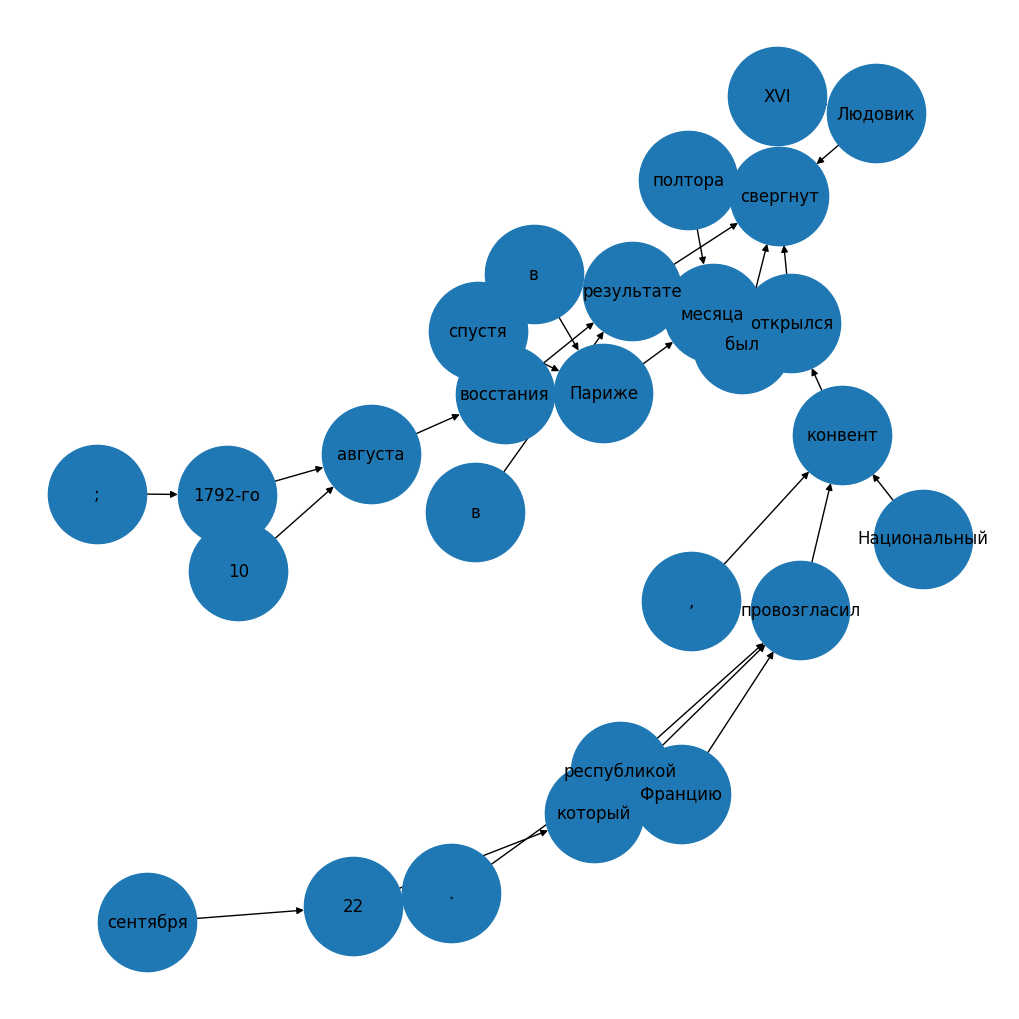

In [192]:
plt.figure(figsize=(10,10))
nx.draw(d.nx_graph(), labels=d.nx_labels, node_size=5000)

In [193]:
d.nx_labels

{1: 'Людовик',
 2: 'XVI',
 3: 'был',
 4: 'свергнут',
 5: 'в',
 6: 'результате',
 7: 'восстания',
 8: '10',
 9: 'августа',
 10: '1792-го',
 11: ';',
 12: 'полтора',
 13: 'месяца',
 14: 'спустя',
 15: 'в',
 16: 'Париже',
 17: 'открылся',
 18: 'Национальный',
 19: 'конвент',
 20: ',',
 21: 'который',
 22: '22',
 23: 'сентября',
 24: 'провозгласил',
 25: 'Францию',
 26: 'республикой',
 27: '.'}

Достанем все поддерево какого-нибудь элемента.

In [195]:
get_subtree(d.nodes, 19)

[19, [18], [24, [21, [22, [23]]], [25], [26]]]

Получается список с вложенными списками. Чтобы представить это все в читаемом формате лучше его раплющить ещё одной рекурсивной функцией (такой как мы написали выше). 

In [196]:
def flatten(l):
    flat = []
    for el in l:
        if not isinstance(el, list):
            flat.append(el)
        else:
            flat += flatten(el)
    return flat

In [198]:
flatten(get_subtree(d.nodes, 19))

[19, 18, 24, 21, 22, 23, 25, 26]

Проверим, что досталось.

In [200]:
[d.nodes[i]['word'] for i in flatten(get_subtree(d.nodes, 19))]

['конвент',
 'Национальный',
 'провозгласил',
 'который',
 '22',
 'сентября',
 'Францию',
 'республикой']

Нужно ещё восстановить порядок.

In [201]:
[d.nodes[i]['word'] for i in sorted(flatten(get_subtree(d.nodes, 19)))]

['Национальный',
 'конвент',
 'который',
 '22',
 'сентября',
 'провозгласил',
 'Францию',
 'республикой']

Попробуем теперь также пройтись по корпусу, найти глаголы и если у этих глаголов есть **nsubj** и **obj** (или **obl**), то достать всё поддерево для них. Возможно таким способом получится доставь главную информацию из каждого предложения и получить саммари текста.

Возьмем ещё сырые тексты.

In [203]:
path_raw = 'Arzamas/texts/'
files_raw = [path_raw+file for file in os.listdir(path_raw)]

In [204]:
text_trees = []

for i, file in enumerate(files):
    parsed_sents = open(file).read().split('\n\n')
    raw = open(files_raw[i]).read()
    text = []
    for sent in parsed_sents:
        tree = [line for line in sent.split('\n') if line[0] != '#']
        text.append('\n'.join(tree))
    text_trees.append((raw, text))

In [205]:
summaries = []

for raw_text, trees in text_trees:
    sov_text = []
    
    for tree in trees:
        d = DependencyGraph(tree)
        
        for node_i, node in d.nodes.items():
            if node['ctag'] == 'VERB' and 'nsubj' in node['deps'] and ('obj' in node['deps']
                                                                       or 'obl' in node['deps']):

                subject = [d.nodes[i]['word'] for i in sorted(flatten(get_subtree(d.nodes, 
                                                                              node['deps']['nsubj'][0])))]
                verb = node['word']

                obj = [d.nodes[i]['word'] for i in sorted(flatten(get_subtree(d.nodes, 
                                                                              node['deps'].get('obj',
                                                                              node['deps'].get('obl'))[0])))]

                sov_text.append((' '.join(subject), verb, ' '.join(obj)))
                
    summaries.append((raw_text, sov_text))
    

In [206]:
summaries[3]

('Лектор разбирает две кантаты-жалобы на совершенно душераздирающий сюжет, аналогов которому в эпоху барокко не было, рассказывает о людоедах в Библии и истории матери-людоеда у Тита Флавия и объясняет, как два итальянских композитора обращаются с этим сюжетом. Лекция была организована проектом "Эшколот" совместно с Итальянским институтом культуры в Москве. \nКонспект лекции можно прочесть здесь.\n\n',
 [('Лектор', 'разбирает', 'Флавия'),
  ('и объясняет как два итальянских композитора',
   'обращаются',
   'с этим сюжетом'),
  ('Лекция', 'организована', 'проектом Эшколот')])

Хороших саммари конечно не получилось. Чтобы довести это до ума нужно будет поправить много вещей: порядок субъекта и дополнения, отрицание, однородные дополнения, сложные предложения, анафору. 

По деревьям зависимостей можно пытаться находить другие интересные завивисимости, но в питоне это делать достаточно сложно. Есть академический ресурс, в котором есть более удобный поиск по таким структурам на данных википедии - https://spike.apps.allenai.org/datasets/wikipediaBasic/search#welcome

## (раздел в процессе написания) datasets от huggingface

Помимо всего вышеперечисленного есть еще огромное количество лингвистических датасетов и перечислить их все не получится. Но если выбрать какую-то одну ссылку, то это будет - https://huggingface.co/datasets